In [73]:
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.core.mutation import Mutation
from pymoo.core.crossover import Crossover
from pymoo.core.sampling import Sampling
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.ox import OrderCrossover
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.optimize import minimize

In [ ]:
class CustomHybridMutation(Mutation):
    """Custom mutation for permutation (sequence) and integer (machine choices)."""    
    def __init__(self, prob=0.1):
        super().__init__()
        self.prob = prob

    def _do(self, problem, X, **kwargs):
        n_individuals, n_var = X.shape
        seq_length = problem.seq_length
        n_stages = problem.n_stages
        Y = X.copy()

        for i in range(n_individuals):
            # Permutation mutation
            if np.random.random() < self.prob:
                idx1, idx2 = np.random.choice(seq_length, size=2, replace=False)
                Y[i, :seq_length][[idx1, idx2]] = Y[i, :seq_length][[idx2, idx1]]
            # Machine choice mutation
            machine_choices = Y[i, seq_length:].reshape(seq_length, n_stages)
            for j in range(seq_length):
                for s in range(n_stages):
                    if np.random.random() < self.prob:
                        machine_choices[j, s] = np.random.randint(0, problem.machines_per_stage[s])
            Y[i, seq_length:] = machine_choices.flatten()

        return Y.astype(int)

class CustomHybridCrossover(Crossover):
    """Custom crossover for permutation and integer parts."""    
    def __init__(self, prob=0.5):
        super().__init__(2, 2)
        self.prob = prob
        self.order_cx = OrderCrossover()
        self.uniform_cx = UniformCrossover(prob=prob)

    def _do(self, problem, X, **kwargs):
        n_parents, n_matings, n_var = X.shape
        seq_length = problem.seq_length
        Y = np.zeros_like(X)

        for k in range(n_matings):
            a, b = X[:, k, :]
            perm_a, perm_b = self.order_cx._do(problem, np.array([[a[:seq_length]], [b[:seq_length]]]))[:, 0, :]
            machine_a, machine_b = self.uniform_cx._do(problem, np.array([[a[seq_length:]], [b[seq_length:]]]))[:, 0, :]
            Y[0, k, :seq_length] = perm_a
            Y[1, k, :seq_length] = perm_b
            Y[0, k, seq_length:] = machine_a
            Y[1, k, seq_length:] = machine_b

        return Y.astype(int)

class CustomHybridSampling(Sampling):
    """Custom sampling for permutation and integer parts."""    
    def _do(self, problem, n_samples, **kwargs):
        seq_length = problem.seq_length
        n_stages = problem.n_stages
        X = np.zeros((n_samples, problem.n_var), dtype=int)

        for i in range(n_samples):
            X[i, :seq_length] = np.random.permutation(seq_length)
            machine_choices = np.zeros((seq_length, n_stages), dtype=int)
            for j in range(seq_length):
                for s in range(n_stages):
                    machine_choices[j, s] = np.random.randint(0, problem.machines_per_stage[s])
            X[i, seq_length:] = machine_choices.flatten()

        return X

In [75]:
class BakeryHybridSchedulingProblem(Problem):
    def __init__(self, user_sequence, recipe_id_to_index, machines_per_stage, processing_times, changeover_times, batch_sizes, tact_times, recipe_ids, debug=False):
        self.seq_length = len(user_sequence)
        self.user_sequence = np.array(user_sequence)
        self.recipe_id_to_index = recipe_id_to_index
        self.n_stages = len(machines_per_stage)
        self.machines_per_stage = machines_per_stage
        self.max_makespan = 0
        self.max_machines = max(machines_per_stage)
        self.debug = debug
        self.recipe_ids = recipe_ids
        n_var = self.seq_length + (self.seq_length * self.n_stages)
        super().__init__(
            n_var=n_var,
            n_obj=1,
            n_constr=0,
            xl=[0] * n_var,
            xu=[self.seq_length - 1] * self.seq_length + [m - 1 for m in machines_per_stage for _ in range(self.seq_length)],
            type_var=int
        )
        self.processing_times = processing_times
        self.changeover_times = changeover_times
        self.batch_sizes = batch_sizes
        self.tact_times = tact_times

    def _evaluate(self, X, out, *args, **kwargs):
        makespans = np.array([self.calculate_makespan(x, store_best=False) for x in X])
        out["F"] = makespans

    def calculate_makespan(self, x, store_best=True):
        # Unpack Solution
        perm = x[:self.seq_length]
        machine_choices = x[self.seq_length:].reshape(self.seq_length, self.n_stages)
        seq = self.user_sequence[perm]
        permuted_batch_sizes = np.array(self.batch_sizes)[perm]

        # Initialize Tracking Arrays
        start_times = np.zeros((self.seq_length, self.n_stages))
        end_times = np.zeros((self.seq_length, self.n_stages))
        changeover_times_array = np.zeros((self.seq_length, self.n_stages))
        machine_free_times = np.zeros((self.n_stages, self.max_machines))
        changeover_start_times = np.zeros((self.seq_length, self.n_stages))
        changeover_end_times = np.zeros((self.seq_length, self.n_stages))        

        for job_idx in range(self.seq_length):
            recipe = seq[job_idx]
            perm_batch_size = permuted_batch_sizes[job_idx]
            
            # --- Stage 0 ---
            stage_idx = 0
            m = machine_choices[job_idx, stage_idx]
            last_job_on_machine = None
            for prev_idx in range(job_idx - 1, -1, -1):
                if machine_choices[prev_idx, stage_idx] == m:
                    last_job_on_machine = prev_idx
                    break
            if last_job_on_machine is None:
                changeover = 0
                changeover_start = 0
                changeover_end = 0
                start_times[job_idx, stage_idx] = max(0, machine_free_times[stage_idx, m])
            else:
                prev_recipe_on_machine = seq[last_job_on_machine]
                if prev_recipe_on_machine != recipe:
                    changeover = self.changeover_times[stage_idx, m, prev_recipe_on_machine, recipe]
                    changeover = changeover.item() if isinstance(changeover, np.ndarray) else changeover
                else:
                    changeover = 0
                changeover_start = end_times[last_job_on_machine, stage_idx]
                changeover_end = changeover_start + changeover
                # allow changeover during idle
                start_times[job_idx, stage_idx] = max(changeover_end, machine_free_times[stage_idx, m])

            # Store changeover times
            changeover_times_array[job_idx, stage_idx] = changeover
            changeover_start_times[job_idx, stage_idx] = changeover_start
            changeover_end_times[job_idx, stage_idx] = changeover_end    

            processing_duration = self.processing_times[stage_idx, m, recipe]
            batch_delay = (perm_batch_size - 1) * self.tact_times[recipe]
            end_times[job_idx, stage_idx] = start_times[job_idx, stage_idx] + processing_duration + batch_delay
            machine_free_times[stage_idx, m] = end_times[job_idx, stage_idx]

            if self.debug and store_best:
                print('--'*10)
                print('Stage 0 calculations:')
                print('job_idx', job_idx)
                print('stage_idx = 0')
                print('m', m)
                print('processing_duration', processing_duration)
                print('changeover_times_array[job_idx, stage_idx]', changeover_times_array[job_idx, stage_idx])
                print('start_times[job_idx, stage_idx]', start_times[job_idx, stage_idx])
                print('machine_free_times[stage_idx, m]', machine_free_times[stage_idx, m])
                print('permuted_batch_sizes[job_idx]', permuted_batch_sizes[job_idx])
                print('--'*10)

            # --- Subsequent Stages ---
            for stage_idx in range(1, self.n_stages):
                m = machine_choices[job_idx, stage_idx]
                last_job_on_machine = None
                for prev_idx in range(job_idx - 1, -1, -1):
                    if machine_choices[prev_idx, stage_idx] == m:
                        last_job_on_machine = prev_idx
                        break
                if last_job_on_machine is None:
                    changeover = 0
                    changeover_start = 0
                    changeover_end = 0
                    start_times[job_idx, stage_idx] = max(0, machine_free_times[stage_idx, m])
                else:
                    prev_recipe_on_machine = seq[last_job_on_machine]
                    if prev_recipe_on_machine != recipe:
                        changeover = self.changeover_times[stage_idx, m, prev_recipe_on_machine, recipe]
                        changeover = changeover.item() if isinstance(changeover, np.ndarray) else changeover
                    else:
                        changeover = 0
                    changeover_start = end_times[last_job_on_machine, stage_idx]
                    changeover_end = changeover_start + changeover
                    # allow changeover during idle
                    start_times[job_idx, stage_idx] = max(changeover_end, machine_free_times[stage_idx, m])

                # Store changeover times
                changeover_times_array[job_idx, stage_idx] = changeover
                changeover_start_times[job_idx, stage_idx] = changeover_start
                changeover_end_times[job_idx, stage_idx] = changeover_end                

                required_start = end_times[job_idx, stage_idx - 1] - (perm_batch_size - 1) * self.tact_times[recipe]
                if last_job_on_machine is not None:
                    ready_time = max(end_times[last_job_on_machine, stage_idx], changeover_end)
                else:
                    ready_time = changeover
                start_times[job_idx, stage_idx] = max(required_start, ready_time, machine_free_times[stage_idx, m])

                if start_times[job_idx, stage_idx] > required_start:
                    postpone_amount = start_times[job_idx, stage_idx] - required_start

                    if self.debug and store_best:
                        print('end_times[last_job_on_machine, stage_idx]', end_times[last_job_on_machine, stage_idx])
                        print('changeover_start:', changeover_start)
                        print('changeover:', changeover)
                        print('changeover_end:', changeover_end)
                        print(f"Postponing recipe ID {self.recipe_ids[recipe]} at Stage {stage_idx} by {postpone_amount} time units to meet no-wait condition.")
                        print(f"  required_start: {required_start}")
                        print(f"  ready_time: {ready_time}")
                        print(f"  machine_free_times[{stage_idx}, {m}]: {machine_free_times[stage_idx, m]}")
                        prev_job = None
                        for prev_idx in range(job_idx - 1, -1, -1):
                            if machine_choices[prev_idx, stage_idx] == m:
                                prev_job = prev_idx
                                break
                        if prev_job is not None:
                            print(f"  Previous job on this machine: Recipe {prev_job} (ID {self.recipe_ids[seq[prev_job]]}), ends at {end_times[prev_job, stage_idx]}")
                        else:
                            print("  No previous job on this machine at this stage.")

                    # Apply postponement to Stage 0 and recalculate all stages for this job
                    start_times[job_idx, 0] += postpone_amount
                    end_times[job_idx, 0] += postpone_amount
                    for ss in range(1, stage_idx + 1):
                        start_times[job_idx, ss] += postpone_amount
                        end_times[job_idx, ss] += postpone_amount
                    for ss in range(stage_idx):
                        m_prev = machine_choices[job_idx, ss]
                        machine_free_times[ss, m_prev] = end_times[job_idx, ss]

                    required_start = end_times[job_idx, stage_idx - 1] - (perm_batch_size - 1) * self.tact_times[recipe]
                    start_times[job_idx, stage_idx] = max(required_start, ready_time, machine_free_times[stage_idx, m])

                processing_duration = self.processing_times[stage_idx, m, recipe]
                batch_delay = (perm_batch_size - 1) * self.tact_times[recipe]
                end_times[job_idx, stage_idx] = start_times[job_idx, stage_idx] + processing_duration + batch_delay
                machine_free_times[stage_idx, m] = end_times[job_idx, stage_idx]

        makespan = np.max(end_times)

        if store_best:
            self.best_start_times = start_times
            self.best_end_times = end_times
            self.best_machine_choices = machine_choices
            self.best_sequence_ids = [self.recipe_ids[idx] for idx in seq]
            self.best_changeover_times = changeover_times_array
            self.best_changeover_start_times = changeover_start_times
            self.best_changeover_end_times = changeover_end_times            
            self.max_makespan = makespan

        return makespan

    def plot_gantt_chart(self):
        fig, ax = plt.subplots(figsize=(14, 7))

        # Build stage_labels and mapping in the desired order: Stage 0 (Machine 0, 1, ...), Stage 1 (Machine 0, 1, ...), ...
        stage_labels = []
        stage_machine_indices = []
        for s in range(self.n_stages):
            for m in range(self.machines_per_stage[s]):
                stage_labels.append(f"Stage {s} (Machine {m})")
                stage_machine_indices.append((s, m))
        # Reverse for plotting: Stage 0 at the top
        stage_labels = stage_labels[::-1]
        stage_machine_indices = stage_machine_indices[::-1]
        y_positions = np.arange(len(stage_labels))

        # Color map for recipes
        unique_recipes = list(dict.fromkeys(self.best_sequence_ids))
        colors = {recipe_id: plt.cm.Set3(i % 12) for i, recipe_id in enumerate(unique_recipes)}

        # Build job labels with occurrence numbers
        recipe_counts = defaultdict(int)
        recipe_total_counts = Counter(self.best_sequence_ids)
        job_labels = []
        for rid in self.best_sequence_ids:
            recipe_counts[rid] += 1
            if recipe_total_counts[rid] > 1:
                job_labels.append(f"{rid} ({recipe_counts[rid]})")
            else:
                job_labels.append(f"{rid}")

        # Add striped background for each stage
        stage_start_idx = 0
        for s in range(self.n_stages):
            n_machines = self.machines_per_stage[s]
            stage_end_idx = stage_start_idx + n_machines
            idx_start = len(stage_labels) - stage_end_idx
            idx_end = len(stage_labels) - stage_start_idx
            if s % 2 == 0:
                ax.axhspan(idx_start - 0.5, idx_end - 0.5, facecolor="#ffffff", alpha=0.5, zorder=0)
            else:
                ax.axhspan(idx_start - 0.5, idx_end - 0.5, facecolor='#f5f5dc', alpha=0.5, zorder=0)
            stage_start_idx = stage_end_idx

        # Plot bars for each job at each stage/machine
        for i in range(self.seq_length):
            recipe_id = self.best_sequence_ids[i]
            label = job_labels[i]
            for s in range(self.n_stages):
                m = self.best_machine_choices[i, s]
                stage_idx = sum(self.machines_per_stage[:s]) + m
                y_idx = len(stage_labels) - 1 - stage_idx

                start_time = self.best_start_times[i, s]
                end_time = self.best_end_times[i, s]
                changeover = self.best_changeover_times[i, s]

                # Draw changeover bar if any
                if changeover > 0:
                    changeover_start = start_time - changeover
                    ax.barh(y_positions[y_idx], changeover, left=changeover_start, height=0.5,
                            color='red', edgecolor='black', alpha=0.7,
                            label='Changeover' if (i == 0 and s == 0) else "")

                # Draw processing+batch bar
                process_duration = end_time - start_time
                ax.barh(y_positions[y_idx], process_duration, left=start_time, height=0.5,
                        color=colors[recipe_id], edgecolor='black')

                # Add job label in the middle of the process bar
                ax.text(start_time + process_duration / 2, y_positions[y_idx], label,
                        ha='center', va='center', color='white', fontweight='bold', fontsize=9)

        # Add vertical major grid lines for x-axis (time)
        ax.grid(axis='x', which='major', linestyle='--', color='gray', alpha=0.5, zorder=0)

        # Move x-axis to the top and remove the bottom axis
        ax.xaxis.set_label_position('top')
        ax.xaxis.tick_top()
        ax.xaxis.set_ticks_position('both')
        ax.spines['bottom'].set_visible(False)
        ax.set_xlabel("Time (Top Axis)")

        ax.set_yticks(y_positions)
        ax.set_yticklabels(stage_labels)
        ax.set_title("Batch Production Scheduling - Multi-stage Flowshop Optimization")
        ax.set_xlim(0, self.max_makespan + 10)
        ax.set_ylim(-0.5, len(stage_labels) - 0.5)
        handles = [plt.Rectangle((0,0),1,1, color=colors[rid], label=str(rid)) for rid in colors.keys()]
        handles.append(plt.Rectangle((0,0),1,1, color='red', alpha=0.7, label='Changeover'))
        ax.legend(handles=handles, loc='best', title="Recipe IDs")

        plt.tight_layout()
        plt.show()


    def export_schedule_for_js(self):
        """Export all job-stage timing info for JS Gantt chart."""
        export = []
        for job_idx in range(self.seq_length):
            for stage_idx in range(self.n_stages):
                export.append({
                    "job_idx": job_idx,
                    "stage_idx": stage_idx,
                    "recipe_id": self.best_sequence_ids[job_idx],
                    "machine": int(self.best_machine_choices[job_idx, stage_idx]),
                    "changeover_start": float(self.best_changeover_start_times[job_idx, stage_idx]),
                    "changeover_end": float(self.best_changeover_end_times[job_idx, stage_idx]),
                    "process_start": float(self.best_start_times[job_idx, stage_idx]),
                    "process_duration": float(self.best_end_times[job_idx, stage_idx] - self.best_start_times[job_idx, stage_idx]),
                    "process_end": float(self.best_end_times[job_idx, stage_idx]),
                })
        return export

In [ ]:
# Example setup
recipe_ids = [1, 3, 4, 5, 8, 14]
recipe_id_to_index = {rid: idx for idx, rid in enumerate(recipe_ids)}

# User's sequence (8 positions)
user_sequence_ids = [3, 1, 5, 8, 14, 3, 5, 5]
user_sequence_idx = [recipe_id_to_index[rid] for rid in user_sequence_ids]

# Problem parameters
n_stages = 5
n_recipes = len(recipe_ids)
machines_per_stage = [2, 2, 1, 2, 3]  # Number of machines at each stage
max_machines = max(machines_per_stage)

# Sample data
np.random.seed(42)

# processing_times = np.random.randint(5, 20, size=(n_stages, max_machines, n_recipes))
base_processing_times = np.random.randint(5, 20, size=(n_stages, n_recipes))
processing_times = np.repeat(base_processing_times[:, np.newaxis, :], max_machines, axis=1)

changeover_times = np.random.randint(15, 21, size=(n_stages, max_machines, n_recipes, n_recipes))
for s in range(n_stages):
    for m in range(machines_per_stage[s]):
        for i in range(n_recipes):
            changeover_times[s, m, i, i] = 0  # No changeover for same recipe
            
# Define batch_sizes to match the sequence length
batch_sizes = [10, 20, 15, 20, 30, 15, 25, 25]  # Example quantities for each position in the user_sequence
tact_times = np.random.randint(3, 6, size=n_recipes)

# Debug print input data
print("recipe_ids:", recipe_ids)
print("recipe_id_to_index:", recipe_id_to_index)
print("User sequence IDs:", user_sequence_ids)
print("User sequence indices:", user_sequence_idx)
print("\n")
print("Batch sizes:", batch_sizes)
print("Tact times:", tact_times)
print("\n")
print("Base_processing_times:\n", base_processing_times)
print("Processing times:\n", processing_times)
print("Changeover times:\n", changeover_times)

recipe_ids: [1, 3, 4, 5, 8, 14]
recipe_id_to_index: {1: 0, 3: 1, 4: 2, 5: 3, 8: 4, 14: 5}
User sequence IDs: [3, 1, 5, 8, 14, 3, 5, 5]
User sequence indices: [1, 0, 3, 4, 5, 1, 3, 3]


Batch sizes: [10, 20, 15, 20, 30, 15, 25, 25]
Tact times: [4 3 4 3 5 3]


Base_processing_times:
 [[11  8 17 19 15 12]
 [17  9 11 14  7 11]
 [15 15 12  9  8 12]
 [12  7 10  9  6 12]
 [16 18 10  6 16  9]]
Processing times:
 [[[11  8 17 19 15 12]
  [11  8 17 19 15 12]
  [11  8 17 19 15 12]]

 [[17  9 11 14  7 11]
  [17  9 11 14  7 11]
  [17  9 11 14  7 11]]

 [[15 15 12  9  8 12]
  [15 15 12  9  8 12]
  [15 15 12  9  8 12]]

 [[12  7 10  9  6 12]
  [12  7 10  9  6 12]
  [12  7 10  9  6 12]]

 [[16 18 10  6 16  9]
  [16 18 10  6 16  9]
  [16 18 10  6 16  9]]]
Changeover times:
 [[[[ 0 18 16 20 19 18]
   [15  0 17 17 16 18]
   [18 20  0 20 17 18]
   [18 15 17  0 17 19]
   [15 16 18 15  0 20]
   [16 16 15 16 19  0]]

  [[ 0 18 18 18 19 17]
   [20  0 18 16 18 16]
   [20 20  0 16 18 20]
   [19 16 16  0 16 16]
 

In [77]:
def minimize_machines_postprocess(problem):
    """
    Try to reassign jobs to fewer machines per stage, without increasing waiting times.
    Updates problem.best_machine_choices in place.
    """

    machine_choices = problem.best_machine_choices.copy()
    start_times = problem.best_start_times
    end_times = problem.best_end_times
    seq_length, n_stages = machine_choices.shape
    machines_per_stage = problem.machines_per_stage

    for s in range(n_stages):
        # For each stage, try to assign jobs to as few machines as possible
        recipe_idx_sorted = np.argsort(start_times[:, s])
        print('sorted jobs for stage', s, ':', recipe_idx_sorted)
        print('sorted recipe ids for stage', s, ':', [problem.best_sequence_ids[j] for j in recipe_idx_sorted])
        assigned = [False] * seq_length
        new_assignments = np.full(seq_length, -1)
        machine_end_times = [0] * machines_per_stage[s]
        used_machines = []

        for recipe_idx in recipe_idx_sorted:
            # Try to assign to an already used machine if possible
            assigned_flag = False
            for m in used_machines:
                # Can this job start after the last job on this machine finished?
                last_end = machine_end_times[m]
                if start_times[recipe_idx, s] >= last_end:
                    new_assignments[recipe_idx] = m
                    machine_end_times[m] = end_times[recipe_idx, s]
                    assigned_flag = True
                    break
            if not assigned_flag:
                # Assign to a new machine
                for m in range(machines_per_stage[s]):
                    if m not in used_machines:
                        new_assignments[recipe_idx] = m
                        machine_end_times[m] = end_times[recipe_idx, s]
                        used_machines.append(m)
                        break

        # Update machine choices for this stage
        machine_choices[:, s] = new_assignments

    # Update the problem with the new machine assignments
    problem.best_machine_choices = machine_choices

    # Optionally, recompute makespan and times for consistency
    # (if you want to update Gantt chart, etc.)
    # You may want to call:
    problem.calculate_makespan(np.concatenate([problem.best_perm, machine_choices.flatten()]), store_best=True)

    print("Post-processing complete. New machine assignments minimize machine usage per stage.")


In [78]:
# Create the problem instance
problem = BakeryHybridSchedulingProblem(
    user_sequence=user_sequence_idx,
    recipe_id_to_index=recipe_id_to_index,
    machines_per_stage=machines_per_stage,
    processing_times=processing_times,
    changeover_times=changeover_times,
    batch_sizes=batch_sizes,
    tact_times=tact_times,
    recipe_ids=recipe_ids,
    debug=True
)

# Define the genetic algorithm
algorithm = GA(
    pop_size=200,
    sampling=CustomHybridSampling(),
    crossover=CustomHybridCrossover(prob=0.5),
    mutation=CustomHybridMutation(prob=0.1),
    eliminate_duplicates=True
)

# Define termination criteria
termination = DefaultSingleObjectiveTermination(
    xtol=1e-6,
    cvtol=1e-6,
    ftol=1e-6,
    period=50,
    n_max_gen=200
)

# Run the optimization
res = minimize(
    problem,
    algorithm,
    termination,
    seed=42,
    verbose=True
)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      200 |  7.842800E+02 |  7.410000E+02
     2 |      400 |  7.666700E+02 |  7.320000E+02


c:\Users\NHPHUC\Desktop\schantt-model\.venv\lib\site-packages\pymoo\util\normalization.py:86: RuntimeWarning: invalid value encountered in cast
  N[..., neither_nan] = (X[..., neither_nan] - xl[neither_nan]) / (xu[neither_nan] - xl[neither_nan])


     3 |      600 |  7.580100E+02 |  7.290000E+02
     4 |      800 |  7.507000E+02 |  7.140000E+02
     5 |     1000 |  7.449300E+02 |  7.140000E+02
     6 |     1200 |  7.395900E+02 |  7.140000E+02
     7 |     1400 |  7.335350E+02 |  7.140000E+02
     8 |     1600 |  7.293150E+02 |  7.090000E+02
     9 |     1800 |  7.251300E+02 |  7.030000E+02
    10 |     2000 |  7.212850E+02 |  7.030000E+02
    11 |     2200 |  7.177750E+02 |  7.030000E+02
    12 |     2400 |  7.145450E+02 |  7.030000E+02
    13 |     2600 |  7.115200E+02 |  7.030000E+02
    14 |     2800 |  7.093200E+02 |  7.030000E+02
    15 |     3000 |  7.073100E+02 |  7.030000E+02
    16 |     3200 |  7.054700E+02 |  7.030000E+02
    17 |     3400 |  7.047900E+02 |  7.030000E+02
    18 |     3600 |  7.046450E+02 |  7.030000E+02
    19 |     3800 |  7.043200E+02 |  7.030000E+02
    20 |     4000 |  7.037450E+02 |  7.030000E+02
    21 |     4200 |  7.031350E+02 |  7.030000E+02
    22 |     4400 |  7.030000E+02 |  7.030000E+02


--------------------
Stage 0 calculations:
job_idx 0
stage_idx = 0
m 1
processing_duration 8
changeover_times_array[job_idx, stage_idx] 0.0
start_times[job_idx, stage_idx] 0.0
machine_free_times[stage_idx, m] 35.0
permuted_batch_sizes[job_idx] 10
--------------------
--------------------
Stage 0 calculations:
job_idx 1
stage_idx = 0
m 1
processing_duration 8
changeover_times_array[job_idx, stage_idx] 0.0
start_times[job_idx, stage_idx] 35.0
machine_free_times[stage_idx, m] 85.0
permuted_batch_sizes[job_idx] 15
--------------------
end_times[last_job_on_machine, stage_idx] 44.0
changeover_start: 44.0
changeover: 0
changeover_end: 44.0
Postponing recipe ID 3 at Stage 1 by 1.0 time units to meet no-wait condition.
  required_start: 43.0
  ready_time: 44.0
  machine_free_times[1, 0]: 44.0
  Previous job on this machine: Recipe 0 (ID 3), ends at 44.0
end_times[last_job_on_machine, stage_idx] 59.0
changeover_start: 59.0
changeover: 0
changeover_end: 59.0
Postponing recipe ID 3 at Stage 2 by 

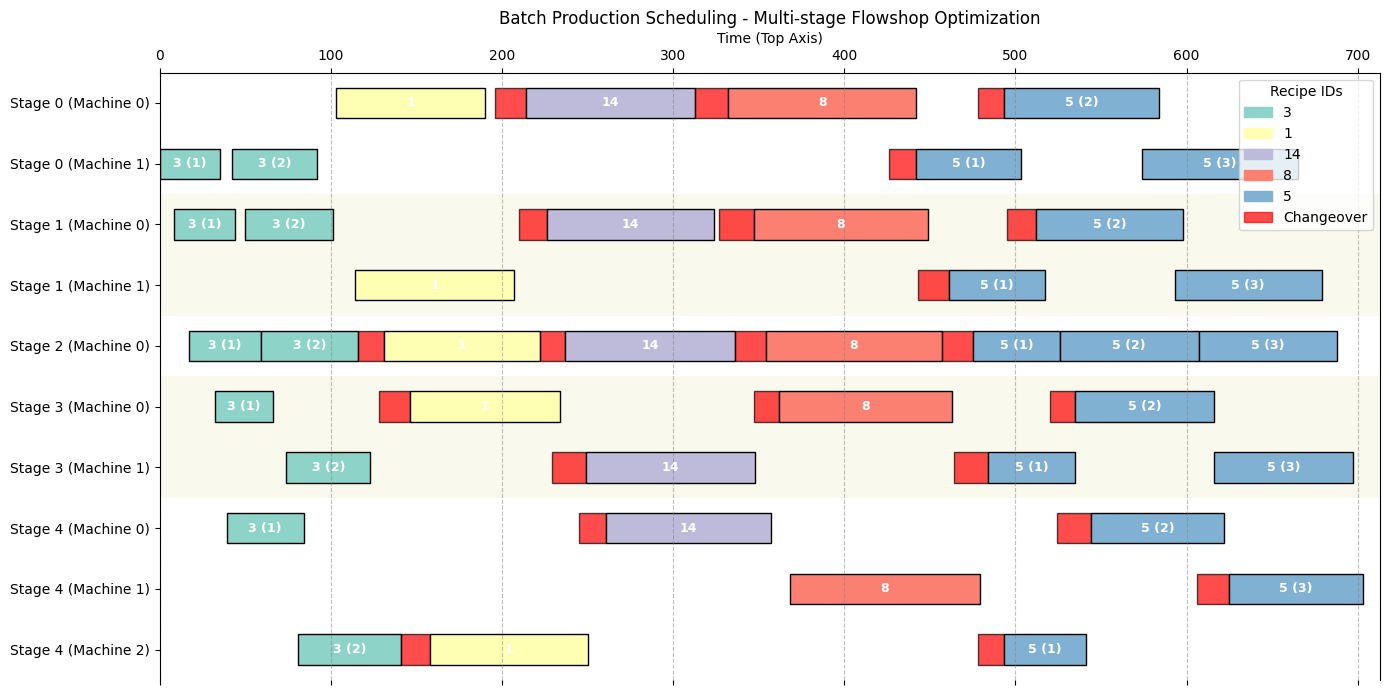

Exported schedule for JS Gantt chart:
{'job_idx': 0, 'stage_idx': 0, 'recipe_id': 3, 'machine': 1, 'changeover_start': 0.0, 'changeover_end': 0.0, 'process_start': 0.0, 'process_duration': 35.0, 'process_end': 35.0}
{'job_idx': 0, 'stage_idx': 1, 'recipe_id': 3, 'machine': 0, 'changeover_start': 0.0, 'changeover_end': 0.0, 'process_start': 8.0, 'process_duration': 36.0, 'process_end': 44.0}
{'job_idx': 0, 'stage_idx': 2, 'recipe_id': 3, 'machine': 0, 'changeover_start': 0.0, 'changeover_end': 0.0, 'process_start': 17.0, 'process_duration': 42.0, 'process_end': 59.0}
{'job_idx': 0, 'stage_idx': 3, 'recipe_id': 3, 'machine': 0, 'changeover_start': 0.0, 'changeover_end': 0.0, 'process_start': 32.0, 'process_duration': 34.0, 'process_end': 66.0}
{'job_idx': 0, 'stage_idx': 4, 'recipe_id': 3, 'machine': 0, 'changeover_start': 0.0, 'changeover_end': 0.0, 'process_start': 39.0, 'process_duration': 45.0, 'process_end': 84.0}
{'job_idx': 1, 'stage_idx': 0, 'recipe_id': 3, 'machine': 1, 'changeo

In [79]:
# --- Extract and display results ---

# Get the best solution from the optimizer
best_x = res.X
best_perm = best_x[:problem.seq_length]
# best_x[:problem.seq_length] = np.array([1, 1, 4, 5, 0, 3, 3, 3])

# Recompute and store the makespan and all best_* attributes
makespan = problem.calculate_makespan(best_x, store_best=True)
problem.best_perm = best_perm  # Store for possible later use

# Post-process to minimize machine usage (Optional)
# print("Unique machines used per stage BEFORE post-processing:")
# for s in range(problem.n_stages):
#     unique_machines = np.unique(problem.best_machine_choices[:, s])
#     print(f"Stage {s}: {len(unique_machines)} machines used: {unique_machines}")

# minimize_machines_postprocess(problem)

# print("Unique machines used per stage AFTER post-processing:")
# for s in range(problem.n_stages):
#     unique_machines = np.unique(problem.best_machine_choices[:, s])
#     print(f"Stage {s}: {len(unique_machines)} machines used: {unique_machines}")

# Print summary of the best solution
print("Original sequence of recipe IDs:", user_sequence_ids)
print("Best permutation of indices:", best_perm)
print("Best sequence of recipe IDs:", problem.best_sequence_ids)
print("Best machine choices per recipe and stage:\n", problem.best_machine_choices)
print("Best makespan:", problem.max_makespan)

# Visualize the schedule
problem.plot_gantt_chart()

# Export schedule for JavaScript Gantt chart
schedule_export = problem.export_schedule_for_js()
# Print the exported schedule
print("Exported schedule for JS Gantt chart:")
for entry in schedule_export:
    print(entry)
    